# Objective:

To apply Naive Bayes on Amazon Food reiviews dataset to classify the reviews into positive and negative. 



In [0]:
# To suprress the warnings as they make the notebook less presentable.

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

Import the necessary libraries.

In [0]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score, confusion_matrix, accuracy_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.naive_bayes import ComplementNB, GaussianNB
import pickle
import numpy as np

This Jupyter notebook extension notifies you when a cell finishes its execution!

In [0]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

## Choice of Naive Bayes

I'm using *ComplementNB* here because it is better suited for unbalanced datasets. According to the scikit-learn documentation of ComplementNB -

>CNB is an adaptation of the standard multinomial naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets. Specifically, CNB uses statistics from the complement of each class to compute the model’s weights. The inventors of CNB show empirically that the parameter estimates for CNB are more stable than those for MNB. Further, CNB regularly outperforms MNB (often by a considerable margin) on text classification tasks.

As this is a text classification problem and also because the dataset is imbalanced, using ComplementNB seems worthwhile.

Load the target variable y for train and test sets.

In [0]:
f = open(r'D:\data_science\datasets\amazon2\y_train_full80_20.pkl', 'rb')
# f = open('/home/ucanreachtvk/data/y_train_full80_20.pkl', 'rb')
y_train = pickle.load(f)
f.close()
print('The datatype of y_train is : {}'.format(type(y_train)))
print('The shape of y_train is : {}'.format(y_train.shape))

The datatype of y_train is : <class 'numpy.ndarray'>
The shape of y_train is : (291336,)


In [0]:
f = open(r'D:\data_science\datasets\amazon2\y_test_full80_20.pkl', 'rb')
# f = open('/home/ucanreachtvk/data/y_test_full80_20.pkl', 'rb')
y_test = pickle.load(f)
f.close()
print('The datatype of y_test is : {}'.format(type(y_test)))
print('The shape of y_test is : {}'.format(y_test.shape))

The datatype of y_test is : <class 'numpy.ndarray'>
The shape of y_test is : (72835,)


## Bag of Words

I had saved the trained BoW model and the transformed data on disk. Let's load them. The entire original data containing around 350k reviews has been used. It is divided into train and test sets in ratio 80:20. 

In [0]:
f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_bow_full_nparray.pkl', 'rb')
# f = open('/home/ucanreachtvk/data/X_train_transformed_bow_full_nparray.pkl', 'rb')
X_train_transformed_bow = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_bow is : {}'.format(type(X_train_transformed_bow)))
print('The shape of X_train_transformed_bow is : {}'.format(X_train_transformed_bow.shape))

The datatype of X_train_transformed_bow is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_train_transformed_bow is : (291336, 64221)


There are 64221 features in the bow representation. Load test data too.

In [0]:
f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_bow_full_nparray.pkl', 'rb')
# f = open('/home/ucanreachtvk/data/X_test_transformed_bow_full_nparray.pkl', 'rb')
X_test_transformed_bow = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_bow is : {}'.format(type(X_test_transformed_bow)))
print('The shape of X_test_transformed_bow is : {}'.format(X_test_transformed_bow.shape))

The datatype of X_test_transformed_bow is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_test_transformed_bow is : (72835, 64221)


## Feature scaling?

Naive bayes is not a distance based algorithm. It only depends on probability calculations. Therefore there's no need to apply standardization to the dataset.

## GridSearchCV

First, split the 80% train data using TimeSeriesSplit() for cross validation then create a Naive Bayes object. Also create the GridSearchCV object which does 10 fold cross validation.

In [0]:
try:
    del(tscv)
    del(my_cv)
    del(clf)
    del(nb)
except:
    print('one or more variables not found.')

tscv = TimeSeriesSplit(n_splits=10)
my_cv = tscv.split(X_train_transformed_bow)

nb = ComplementNB()
#nb = MultinomialNB()

hyp_par = {
            'alpha':[0.001, 0.01, 0.1, 10, 100, 1000, 10000]
          }

clf = GridSearchCV(estimator=nb, cv=my_cv, param_grid=hyp_par, n_jobs=4, return_train_score=True, pre_dispatch=2)

one or more variables not found.


In [0]:
%%notify
%%time

clf.fit(X_train_transformed_bow, y_train)

Wall time: 18.1 s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000002AFDE5E6DB0>,
       error_score='raise-deprecating',
       estimator=ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'alpha': [0.001, 0.01, 0.1, 10, 100, 1000, 10000]},
       pre_dispatch=2, refit=True, return_train_score=True, scoring=None,
       verbose=0)

<IPython.core.display.Javascript object>

Import prettytable to summarize the results in a table

In [0]:
#!pip install PrettyTable
#from prettytable import PrettyTable
from prettytable import PrettyTable
table = PrettyTable()

Let's define a couple of functions that we'll use.

* give_me_ratios()

* plot_confusion_matrix()
  
The first function takes the training and test data and creates a table containing various ratios like precision, recall, FPR, TPR, etc.

The second function plots a confusion matrix for training and test datasets.


In [0]:
def give_me_ratios(X_train, y_train, X_test, y_test, vector_type, table): 
    
    cm_train = confusion_matrix(y_train, clf.predict(X_train))
    tn, fp, fn, tp = cm_train.ravel()

    recall_train = round(tp/(tp+fn),2)
    precision_train = round(tp/(tp+fp),2)
    tnr_train = round(tn/(tn+fp),2)
    fpr_train = round(fp/(fp+tn),2)
    fnr_train = round(fn/(fn+tp),2)
    accuracy_train = round((tp+tn)/(tp+tn+fp+fn))
    accuracy_train = (tp+tn)/(tp+tn+fp+fn)

    cm_test = confusion_matrix(y_test, clf.predict(X_test))
    tn, fp, fn, tp = cm_test.ravel()
    recall_test = round(tp/(tp+fn),2)
    precision_test = round(tp/(tp+fp),2)
    tnr_test = round(tn/(tn+fp),2)
    fpr_test = round(fp/(fp+tn),2)
    fnr_test = round(fn/(fn+tp),2)
    accuracy_test = round(tp+tn)/(tp+tn+fp+fn)

    table.field_names = ['Vector Type','Data Set', 'Precision', 'Recall', 'TNR', 'FPR', 'FNR', 'Accuracy']
    table.add_row([vector_type,'Train', precision_train, recall_train, tnr_train, fpr_train, fnr_train, accuracy_train])
    table.add_row([vector_type,'Test', precision_test, recall_test, tnr_test, fpr_test, fnr_test, accuracy_test])

    print(table)
    
    return (cm_train, cm_test)

In [0]:
def plot_confusion_matrix(cm_train, cm_test):
    
    import pandas as pd
    plt.figure(figsize=(15,6))
    
    plt.subplot(1,2,1)
    df_cm = pd.DataFrame(cm_train, range(2), range(2))
    sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.title('Train Data', fontsize = 14)

    plt.subplot(1,2,2)    
    df_cm = pd.DataFrame(cm_test, range(2), range(2))
    sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xticks(fontsize=13)
    plt.xticks(fontsize=13)
    plt.title('Test Data', fontsize = 14)

    plt.tight_layout()

Calculate the ratios.

In [0]:
cm_bow_train, cm_bow_test = give_me_ratios(X_train_transformed_bow, y_train, X_test_transformed_bow, y_test, 'Bag of Words', table)

+--------------+----------+-----------+--------+------+------+------+--------------------+
| Vector Type  | Data Set | Precision | Recall | TNR  | FPR  | FNR  |      Accuracy      |
+--------------+----------+-----------+--------+------+------+------+--------------------+
| Bag of Words |  Train   |    0.91   |  0.98  | 0.44 | 0.56 | 0.02 | 0.8990512672652882 |
| Bag of Words |   Test   |    0.89   |  0.98  | 0.43 | 0.57 | 0.02 | 0.8875677902107503 |
+--------------+----------+-----------+--------+------+------+------+--------------------+


Plot the confusion matrix.

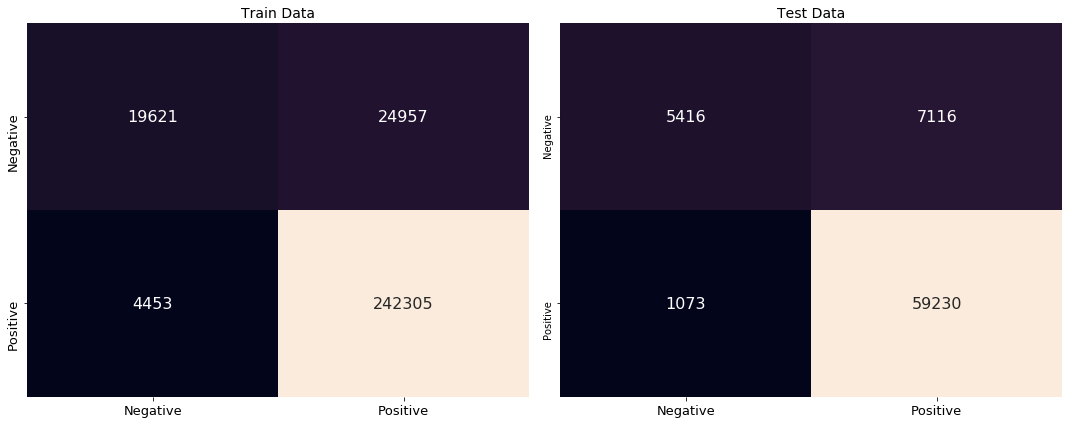

In [0]:
plot_confusion_matrix(cm_bow_train, cm_bow_test)

### Feature Importance

Let's look at the log probabilities of feature importances, for each class.

In [0]:
clf.best_estimator_.feature_log_prob_

array([[13.63213064, 12.56168923, 13.71914202, ..., 13.71914202,
        13.71914202, 13.71914202],
       [12.41965302, 12.32434284, 12.41965302, ..., 12.41965302,
        12.41965302, 12.41965302]])

Notice the shape of this array. For each class along the rows, it gives log probabilities for all words, which are along the columns.

In [0]:
clf.best_estimator_.feature_log_prob_.shape

(2, 64221)

Let's sort the probabilities such that in each row, the probabilities are in descending order. The argsort function is used to get the indexes of the probabilities in their sorted position. But it sorts in the ascending order by default. 

We first reverse the array with [::-1], select the needed row (0/1) and fetch the index of the top 25 features with the highest probability.

Why do we need the indices of the words? Because we need to know which index corresponds to which word in the BoW trained model.

In [0]:
top_features_negative_bow_index = np.argsort(clf.best_estimator_.feature_log_prob_)[::-1][0][:25].tolist()

In [0]:
top_features_positive_bow_index = np.argsort(clf.best_estimator_.feature_log_prob_)[::-1][1][:25].tolist()

Load the fit BoW model which contains the word to index mapping.

In [0]:
f = open(r'D:\data_science\datasets\amazon2\bow_fit_model_full.pkl', 'rb')
#f = open('/home/ucanreachtvk/data/bow_fit_model_full.pkl', 'rb')
bow_fit = pickle.load(f)
f.close()

The bow fit model has an attribute that stores the index of each word against the word. But we need the word from its key, not the key from the word! So let's reverse the mapping of the dictionary.

In [0]:
inv_map = {v:k for k, v in bow_fit.vocabulary_.items()}

Printing the top 25 negative words.

In [0]:
for ind in top_features_negative_bow_index:
    print(inv_map[ind], end=' | ')

tast | like | product | one | flavor | would | tri | good | coffe | use | get | buy | order | food | tea | dont | box | even | amazon | make | bag | much | eat | time | realli | 

Printing the top 25 positive words

In [0]:
for ind in top_features_positive_bow_index:
    print(inv_map[ind], end=' | ')

like | tast | good | flavor | love | great | use | one | product | tea | tri | coffe | make | get | food | time | would | buy | eat | realli | amazon | find | price | best | also | 

Finally, let's calculate the accuracy using the best classifier found by gridsearch.

In [0]:
clf.score(X_test_transformed_bow, y_test)

0.8875677902107503

## Tfidf

In this section, we'll apply Naive Bayes on reviews represented in the Tfidf format. Load the transformed train and test sets.

In [0]:
f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_tfidf_full_nparray.pkl', 'rb')
X_train_transformed_tfidf = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_tfidf is : {}'.format(type(X_train_transformed_tfidf)))
print('The shape of X_train_transformed_tfidf is : {}'.format(X_train_transformed_tfidf.shape))

The datatype of X_train_transformed_tfidf is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_train_transformed_tfidf is : (291336, 64221)


In [0]:
f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_tfidf_full_nparray.pkl', 'rb')
X_test_transformed_tfidf = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_bow is : {}'.format(type(X_test_transformed_tfidf)))
print('The shape of X_test_transformed_bow is : {}'.format(X_test_transformed_tfidf.shape))

The datatype of X_test_transformed_bow is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_test_transformed_bow is : (72835, 64221)


GridSearchCV

In [0]:
try:
    del(tscv)
    del(my_cv)
    del(clf)
    del(nb)
except:
    print('one or more variables not found.')

tscv = TimeSeriesSplit(n_splits=10)
my_cv = tscv.split(X_train_transformed_tfidf)

nb = ComplementNB()
#nb = MultinomialNB()

hyp_par = {
            'alpha':[0.001, 0.01, 0.1, 10, 100, 1000, 10000]
          }

clf = GridSearchCV(estimator=nb, cv=my_cv, param_grid=hyp_par, n_jobs=4, return_train_score=True, pre_dispatch=2)

In [0]:
%%notify
%%time

clf.fit(X_train_transformed_tfidf, y_train)

Wall time: 14.2 s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000002AFDE73B728>,
       error_score='raise-deprecating',
       estimator=ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'alpha': [0.001, 0.01, 0.1, 10, 100, 1000, 10000]},
       pre_dispatch=2, refit=True, return_train_score=True, scoring=None,
       verbose=0)

<IPython.core.display.Javascript object>

Upadate the table with ratios for Tfidf

In [0]:
cm_tfidf_train, cm_tfidf_test = give_me_ratios(X_train_transformed_tfidf, y_train, X_test_transformed_tfidf, y_test, 'Tfidf', table)

+--------------+----------+-----------+--------+------+------+------+--------------------+
| Vector Type  | Data Set | Precision | Recall | TNR  | FPR  | FNR  |      Accuracy      |
+--------------+----------+-----------+--------+------+------+------+--------------------+
| Bag of Words |  Train   |    0.91   |  0.98  | 0.44 | 0.56 | 0.02 | 0.8990512672652882 |
| Bag of Words |   Test   |    0.89   |  0.98  | 0.43 | 0.57 | 0.02 | 0.8875677902107503 |
|    Tfidf     |  Train   |    0.97   |  0.89  | 0.87 | 0.13 | 0.11 | 0.8871955405442513 |
|    Tfidf     |   Test   |    0.96   |  0.87  | 0.81 | 0.19 | 0.13 | 0.860561543214114  |
+--------------+----------+-----------+--------+------+------+------+--------------------+


Plot the confusion matrix.

* y-axis : Actual class
* x-axis : Predicted class

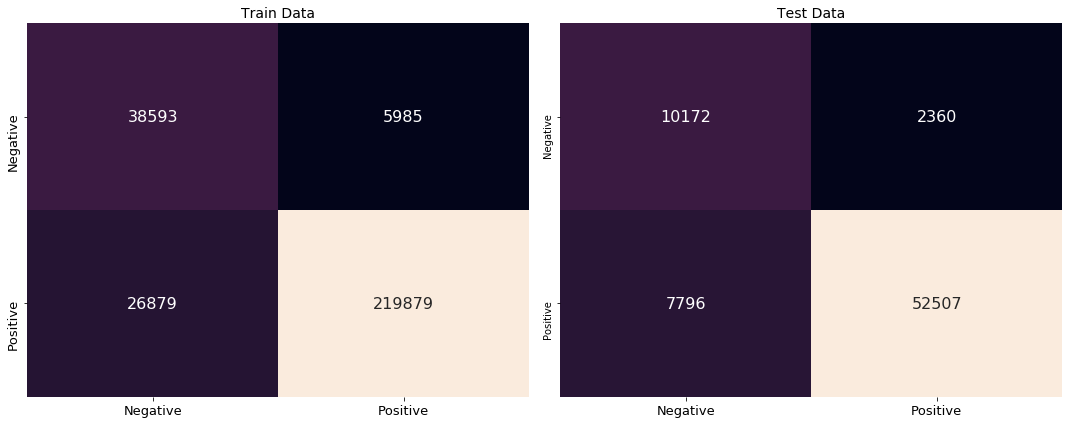

In [0]:
plot_confusion_matrix(cm_tfidf_train, cm_tfidf_test)

Log probabilities of features.

In [0]:
clf.best_estimator_.feature_log_prob_

array([[14.60628932, 12.57943632, 14.59455541, ..., 14.67032303,
        14.78008342, 14.46814714],
       [14.60638248, 13.45078789, 14.60638248, ..., 14.60638248,
        14.60638248, 14.60638248]])

Extract the indices of the top 25 positive and negative words (features)

In [0]:
top_features_negative_tfidf_index = np.argsort(clf.best_estimator_.feature_log_prob_)[::-1][0][:25].tolist()
top_features_positive_tfidf_index = np.argsort(clf.best_estimator_.feature_log_prob_)[::-1][1][:25].tolist()

Load the Tfidf model

In [0]:
f = open(r'D:\data_science\datasets\amazon2\tfidf_fit_model_full.pkl', 'rb')
#f = open('/home/ucanreachtvk/data/bow_fit_model_full.pkl', 'rb')
tfidf_fit = pickle.load(f)
f.close()

In [0]:
inv_map = {v:k for k, v in tfidf_fit.vocabulary_.items()}

Top 25 negaive words

In [0]:
for ind in top_features_negative_tfidf_index:
    print(inv_map[ind], end=' | ')

tast | like | product | would | flavor | coffe | one | tri | buy | order | box | tea | disappoint | good | dont | get | use | even | food | bag | bad | purchas | amazon | much | packag | 

Top 25 positive words

In [0]:
for ind in top_features_positive_tfidf_index:
    print(inv_map[ind], end=' | ')

great | love | tast | good | like | tea | flavor | coffe | product | use | one | tri | make | get | price | best | buy | food | amazon | find | order | time | realli | eat | store | 

In [0]:
clf.score(X_test_transformed_tfidf, y_test)

## Avg W2V

In this section, we'll apply NB on data represented in the avg. W2V format.
load the train and test data stored on disk.

In [0]:
f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
X_train_transformed_avgW2V = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_avgW2V is : {}'.format(type(X_train_transformed_avgW2V)))
print('The shape of X_train_transformed_avgW2V is : {}'.format(X_train_transformed_avgW2V.shape))

The datatype of X_train_transformed_avgW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_avgW2V is : (291336, 50)


In [0]:
f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
X_test_transformed_avgW2V = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_avgW2V is : {}'.format(type(X_test_transformed_avgW2V)))
print('The shape of X_test_transformed_avgW2V is : {}'.format(X_test_transformed_avgW2V.shape))

The datatype of X_test_transformed_avgW2V is : <class 'numpy.ndarray'>
The shape of X_test_transformed_avgW2V is : (72835, 50)


GridSearch

We use GaussianNB for W2V, because there are negative values in the W2V matrix and MultinomialNB/ComplementNB works with only positive values.

In [0]:
try:
    del(tscv)
    del(my_cv)
    del(clf)
    del(nb)
except:
    print('one or more variables not found.')

tscv = TimeSeriesSplit(n_splits=10)
my_cv = tscv.split(X_train_transformed_avgW2V)

nb = GaussianNB()
#nb = ComplementNB()
#nb = MultinomialNB()

hyp_par = {
                #'alpha':[0.001, 0.01, 0.1, 10, 100, 1000, 10000]
                'var_smoothing':[1e-09, 1e-06, 1e-03,1e-00]
          }

clf = GridSearchCV(estimator=nb, cv=my_cv, param_grid=hyp_par, n_jobs=4, return_train_score=True, pre_dispatch=2)

In [0]:
%%notify
%%time

clf.fit(X_train_transformed_avgW2V, y_train)

Wall time: 20 s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000002AFDE73BE08>,
       error_score='raise-deprecating',
       estimator=GaussianNB(priors=None, var_smoothing=1e-09),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'var_smoothing': [1e-09, 1e-06, 0.001, 1.0]},
       pre_dispatch=2, refit=True, return_train_score=True, scoring=None,
       verbose=0)

<IPython.core.display.Javascript object>

Update the table with values of Avg. W2V.

In [0]:
cm_w2v_train, cm_w2v_test = give_me_ratios(X_train_transformed_avgW2V, y_train, X_test_transformed_avgW2V, y_test, 'Avg. W2V', table)

+--------------+----------+-----------+--------+------+------+------+--------------------+
| Vector Type  | Data Set | Precision | Recall | TNR  | FPR  | FNR  |      Accuracy      |
+--------------+----------+-----------+--------+------+------+------+--------------------+
| Bag of Words |  Train   |    0.91   |  0.98  | 0.44 | 0.56 | 0.02 | 0.8990512672652882 |
| Bag of Words |   Test   |    0.89   |  0.98  | 0.43 | 0.57 | 0.02 | 0.8875677902107503 |
|    Tfidf     |  Train   |    0.97   |  0.89  | 0.87 | 0.13 | 0.11 | 0.8871955405442513 |
|    Tfidf     |   Test   |    0.96   |  0.87  | 0.81 | 0.19 | 0.13 | 0.860561543214114  |
|   Avg. W2V   |  Train   |    0.85   |  0.98  | 0.07 | 0.93 | 0.02 | 0.8424636845429333 |
|   Avg. W2V   |   Test   |    0.84   |  0.98  | 0.07 | 0.93 | 0.02 | 0.8249056085673097 |
+--------------+----------+-----------+--------+------+------+------+--------------------+


Plot the confusion matrix.

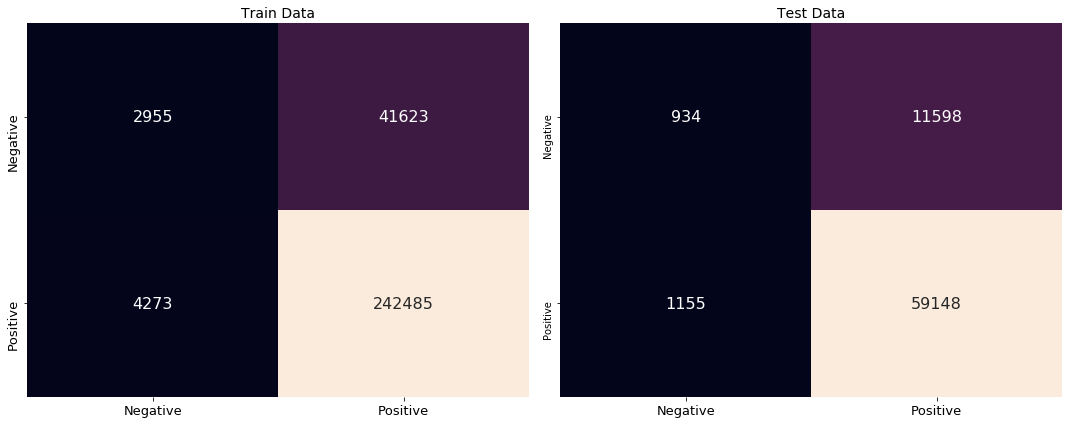

In [0]:
plot_confusion_matrix(cm_w2v_train, cm_w2v_test)

In [0]:
clf.score(X_test_transformed_avgW2V, y_test)

0.8249056085673097

## Tfidf weighted W2V

In this last section, we apply NB on vectors represented in the form of Tfidf weighted W2V.

In [0]:
f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
X_train_transformed_TfidfW2V = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_TfidfW2V is : {}'.format(type(X_train_transformed_TfidfW2V)))
print('The shape of X_train_transformed_TfidfW2V is : {}'.format(X_train_transformed_TfidfW2V.shape))

The datatype of X_train_transformed_TfidfW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_TfidfW2V is : (291336, 50)


In [0]:
f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
X_test_transformed_TfidfW2V = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_TfidfW2V is : {}'.format(type(X_test_transformed_TfidfW2V)))
print('The shape of X_train_transformed_TfidfW2V is : {}'.format(X_test_transformed_TfidfW2V.shape))

The datatype of X_test_transformed_TfidfW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_TfidfW2V is : (72835, 50)


Split the data for cross validation and create Gridsearch object.

In [0]:
try:
    del(tscv)
    del(my_cv)
    del(clf)
    del(nb)
except:
    print('one or more variables not found.')

tscv = TimeSeriesSplit(n_splits=10)
my_cv = tscv.split(X_train_transformed_TfidfW2V)

nb = GaussianNB()
#nb = ComplementNB()
#nb = MultinomialNB()

hyp_par = {
            'var_smoothing':[1e-09, 1e-06, 1e-03,1e-00]
          }

clf = GridSearchCV(estimator=nb, cv=my_cv, param_grid=hyp_par, n_jobs=4, return_train_score=True, pre_dispatch=2)

In [0]:
%%notify
%%time

clf.fit(X_train_transformed_TfidfW2V, y_train)

Wall time: 20.1 s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000002AFDF334048>,
       error_score='raise-deprecating',
       estimator=GaussianNB(priors=None, var_smoothing=1e-09),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'var_smoothing': [1e-09, 1e-06, 0.001, 1.0]},
       pre_dispatch=2, refit=True, return_train_score=True, scoring=None,
       verbose=0)

<IPython.core.display.Javascript object>

Update table with values for Tfidf weighted W2V.

In [0]:
cm_Tfidfw2v_train, cm_Tfidfw2v_test = give_me_ratios(X_train_transformed_TfidfW2V, y_train, X_test_transformed_TfidfW2V, y_test, 'Tfidf Weighted W2V', table)

+--------------------+----------+-----------+--------+------+------+------+--------------------+
|    Vector Type     | Data Set | Precision | Recall | TNR  | FPR  | FNR  |      Accuracy      |
+--------------------+----------+-----------+--------+------+------+------+--------------------+
|    Bag of Words    |  Train   |    0.91   |  0.98  | 0.44 | 0.56 | 0.02 | 0.8990512672652882 |
|    Bag of Words    |   Test   |    0.89   |  0.98  | 0.43 | 0.57 | 0.02 | 0.8875677902107503 |
|       Tfidf        |  Train   |    0.97   |  0.89  | 0.87 | 0.13 | 0.11 | 0.8871955405442513 |
|       Tfidf        |   Test   |    0.96   |  0.87  | 0.81 | 0.19 | 0.13 | 0.860561543214114  |
|      Avg. W2V      |  Train   |    0.85   |  0.98  | 0.07 | 0.93 | 0.02 | 0.8424636845429333 |
|      Avg. W2V      |   Test   |    0.84   |  0.98  | 0.07 | 0.93 | 0.02 | 0.8249056085673097 |
| Tfidf Weighted W2V |  Train   |    0.86   |  0.99  | 0.13 | 0.87 | 0.01 | 0.8592621577834528 |
| Tfidf Weighted W2V |   Test 

Plot confusion matrix.

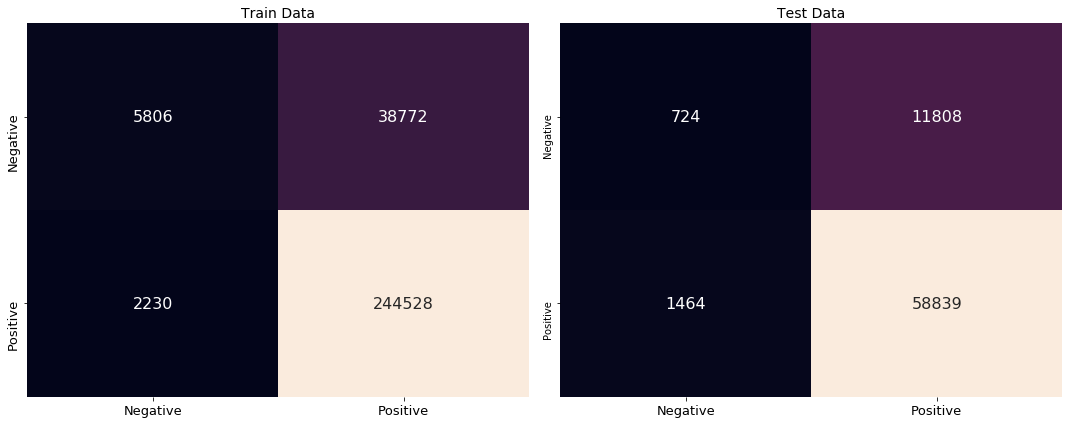

In [0]:
plot_confusion_matrix(cm_Tfidfw2v_train, cm_Tfidfw2v_test)

Accuracy on test data.

In [0]:
clf.score(X_test_transformed_TfidfW2V, y_test)

0.8177799135031235

### Conclusion:

* In this notebook, I applied Naive Bayes on amazon food reviews for various vector representaions.

* The consolidated summary of various ratios can be found in the table above.
